In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
class PoissonProcess():
    
    def __init__(self, t, T, lbd):
        
        self.t = t
        self.T = T
        self.N = int(T/t)
        self.lbd = lbd
        poisson_rvs = ss.poisson.rvs(lbd*self.t, size=self.N)
        self.increments = poisson_rvs
        self.trajectory = np.concatenate([np.zeros(1), np.cumsum(poisson_rvs)])
        
    def plot(self):
        
        plt.plot(np.arange(0, self.T+self.t, step=self.t), self.trajectory)
        plt.ylabel("$N_t$")
        plt.xlabel("t")
        plt.title(f'Poisson process with $\delta t = {self.t}$, $T = {self.T}$ and $\lambda = {self.lbd}$')
        plt.show()
        
    def EN(self):
        return np.mean(self.trajectory)
    
    def VarN(self):
        return np.var(self.trajectory)
    
    def ENt(self):
        return [np.mean(self.trajectory[:i]) for i in np.arange(1, self.N + 1)]
    
    def VarNt(self):
        return [np.var(self.trajectory[:i]) for i in np.arange(1, self.N + 1)]
    

def generate_pareto(lbd, alpha, num):
    uni_rand = ss.uniform.rvs(size=num)
    return lbd/((1-uni_rand)**(1/alpha)) - lbd
        
class CompoundPoisson():
    
    def __init__(self, poisson_process, distribution, parameters):
        
        self.t = poisson_process.t
        self.T = poisson_process.T
        self.N = poisson_process.N
        self.poisson_trajectory = poisson_process.trajectory
        
        if distribution == "exp":
            self.X = ss.expon.rvs(scale=parameters["lmbd"], size=int(self.poisson_trajectory[-1]))
            # self.exp_X = 1/parameters["lmbd"]
            self.exp_X = parameters["lmbd"]
        elif distribution == "pareto":
            self.X = ss.lomax.rvs(c=parameters["alpha"], scale=parameters["lmbd"], size=int(self.poisson_trajectory[-1]))
            self.exp_X = parameters["lmbd"]/(parameters["alpha"] - 1)
        elif distribution == "uniform":
            self.X = ss.uniform.rvs(parameters["a"], parameters["b"], size=int(self.poisson_trajectory[-1]))
            self.exp_X = (parameters["a"] + parameters["b"])/2
        elif distribution == "mixed":
            choices = np.random.choice([1, 2], size=int(self.poisson_trajectory[-1]), p=[parameters["p"], 1 - parameters["p"]])
            self.X = np.where(choices == 1, ss.expon.rvs(scale=parameters["lmbd_1"], size=int(self.poisson_trajectory[-1])), ss.expon.rvs(scale=parameters["lmbd_2"], size=int(self.poisson_trajectory[-1])))
            self.exp_X = parameters["p"] * parameters["lmbd_1"] + (1-parameters["p"]) * parameters["lmbd_2"]
        
        self.trajectory = [np.sum(self.X[:int(n)]) for n in self.poisson_trajectory]
        self.exp_N = poisson_process.lbd
        
    def plot(self):
        
        plt.plot(np.arange(0, self.T + self.t, step=self.t), self.trajectory)    

#theta = 0.1        
class RuinProcess():
    
    def __init__(self, X_distribution, X_parameters, theta=0.1, poisson_lbd=10, delta_t=0.01, T=10):
        
        self.X_distribution = X_distribution
        self.X_parameters = X_parameters
        
        self.poisson_lbd = poisson_lbd
        self.delta_t = delta_t
        self.T = T
        
        self.theta = theta
        
        
    def simulate(self, u0=0):
        
        compound_poisson = CompoundPoisson(PoissonProcess(self.delta_t, self.T, self.poisson_lbd), self.X_distribution, self.X_parameters)
        
        self.ruin_process_time_series = u0 + (1+ self.theta)*compound_poisson.exp_X*self.poisson_lbd*np.arange(0, self.T + self.delta_t, step=self.delta_t) - compound_poisson.trajectory
     
        
    def MC_simulate(self, steps, T_arr):
        
        self.mcs = steps
                
        for T in T_arr:
            if T > self.T:
                raise ValueError(f'{T} is bigger than {self.T}')
                
        min_vals_vec = np.zeros((len(T_arr), steps))
        
        for mcs in np.arange(steps):
            self.simulate(u0=0)
            for i, T in enumerate(T_arr):
                min_vals_vec[(i, mcs)] = np.min(self.ruin_process_time_series[:int(T/self.delta_t)])
                
        self.T_arr = T_arr
        self.min_vals_vec = min_vals_vec
        
     
    def MC_ruin_probability(self, u_vec = np.arange(0, 100), plot=True):
        
        self.ruin_probability_MC = {}
        self.u_vec = u_vec
        
        for i, T in enumerate(self.T_arr):
            self.ruin_probability_MC[T] = np.zeros(len(u_vec))
            for j, u in enumerate(u_vec):
                min_vals_u_vec = self.min_vals_vec[i] + u
                self.ruin_probability_MC[T][j] = np.sum(min_vals_u_vec < 0)/self.mcs
        
        if plot:  
            for T in self.T_arr:      
                plt.plot(u_vec, self.ruin_probability_MC[T], label=f'T={T}')
            plt.legend()
            plt.xlabel("$u_0$")
            plt.ylabel("Probability of ruin")
                      
    def PC_simulate(self, steps):
        
        self.PC_steps = steps
        
        N_vec = np.zeros(steps)
        
        for step in np.arange(steps):
            num_of_aggregate_losses = ss.geom.rvs(p=(self.theta/(1+self.theta))) - 1
            
            if self.X_distribution == "pareto":
                N_vec[step] = np.sum(ss.lomax.rvs(scale=self.X_parameters["lmbd"], c=self.X_parameters["alpha"]-1, size=int(num_of_aggregate_losses)))
            
            elif self.X_distribution == "exp":
                N_vec[step] = np.sum(ss.expon.rvs(scale=self.X_parameters["lmbd"], size=int(num_of_aggregate_losses)))
                
            elif self.X_distribution == "uniform":
                N_vec[step] = np.sum(ss.triang.rvs(self.X_parameters["a"], loc=0, scale=self.X_parameters["b"], size=int(num_of_aggregate_losses)))
                
            elif self.X_distribution == "mixed":
                old_p = self.X_parameters["p"]
                lmbd_1 = self.X_parameters["lmbd_1"]
                lmbd_2 = self.X_parameters["lmbd_2"]
                
                new_p = (old_p*lmbd_2)/(old_p*lmbd_2 + (1-old_p)*lmbd_1)
                
                choices = np.random.choice([1, 2], size=int(num_of_aggregate_losses), p=[new_p, 1 - new_p])
                N_vec[step] = np.sum(np.where(choices == 1, ss.expon.rvs(scale=lmbd_1, size=int(num_of_aggregate_losses)), ss.expon.rvs(scale=lmbd_2, size=int(num_of_aggregate_losses))))
                
        
        self.N_vec = N_vec
        
    def PC_ruin_probability(self, u_vec = np.arange(0, 100), plot=True):
        
        self.ruin_probability_PC = np.zeros(len(u_vec))
        self.u_vec = u_vec
        
        for j, u in enumerate(u_vec):
            self.ruin_probability_PC[j] = np.sum(self.N_vec > u)/self.PC_steps
        
        if plot:
            plt.plot(u_vec, self.ruin_probability_PC)
            plt.legend()
            plt.xlabel("$u_0$")
            plt.ylabel("Probability of ruin")
        
        
    def Vylder_simulate(self):
        
        if self.X_distribution == "exp":
            p1 = ss.expon.moment(1, scale=self.X_parameters["lmbd"])
            p2 = ss.expon.moment(2, scale=self.X_parameters["lmbd"])
            p3 = ss.expon.moment(3, scale=self.X_parameters["lmbd"])
            
        elif self.X_distribution == "uniform":
            p1 = ss.uniform.moment(1, loc=self.X_parameters["a"], scale=self.X_parameters["b"])
            p2 = ss.uniform.moment(2, loc=self.X_parameters["a"], scale=self.X_parameters["b"])
            p3 = ss.uniform.moment(3, loc=self.X_parameters["a"], scale=self.X_parameters["b"]) 
            
        elif self.X_distribution == "mixed":
            p1 = self.X_parameters["p"]*ss.expon.moment(1, scale=self.X_parameters["lmbd_1"]) + (1-self.X_parameters["p"])*ss.expon.moment(1, scale=self.X_parameters["lmbd_2"])
            p2 = self.X_parameters["p"]*ss.expon.moment(2, scale=self.X_parameters["lmbd_1"]) + (1-self.X_parameters["p"])*ss.expon.moment(2, scale=self.X_parameters["lmbd_2"])
            p3 = self.X_parameters["p"]*ss.expon.moment(3, scale=self.X_parameters["lmbd_1"]) + (1-self.X_parameters["p"])*ss.expon.moment(3, scale=self.X_parameters["lmbd_2"])
        
        elif self.X_distribution == "pareto":
            p1 = ss.lomax.moment(1, c=self.X_parameters["alpha"], scale=self.X_parameters["lmbd"])
            p2 = ss.lomax.moment(2, c=self.X_parameters["alpha"], scale=self.X_parameters["lmbd"])
            p3 = ss.lomax.moment(3, c=self.X_parameters["alpha"], scale=self.X_parameters["lmbd"])
            
        self.lmbd_de_Vylder = 3*p2/p3
        self.theta_de_Vylder = ((2*p1*p3)/(3*p2**2))*self.theta
        
    def Vylder_ruin_probability(self, u_vec = np.arange(0, 100), plot=True):
        
        self.ruin_probability_V = (1/(1+self.theta_de_Vylder))*np.exp(-(self.lmbd_de_Vylder*self.theta_de_Vylder*u_vec)/(1 + self.theta_de_Vylder))
        
        if plot:
            plt.plot(u_vec, self.ruin_probability_V)
            plt.xlabel("$u_0$")
            plt.ylabel("Probability of ruin")


## Task 1.

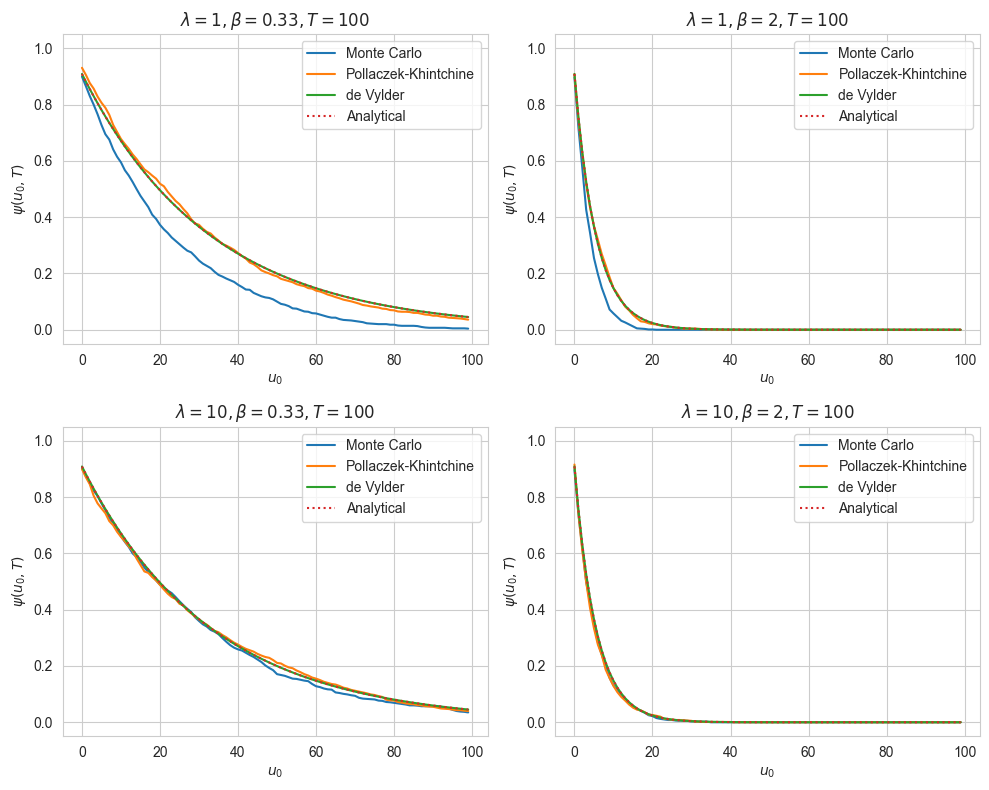

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
steps = 1000
u_vec = np.arange(0, 100)

for i, poiss_lamb in enumerate([1, 10]):
    for j, beta in enumerate([1/3, 2]):
        rp = RuinProcess("exp", {"lmbd":1/beta}, poisson_lbd=poiss_lamb, T=100)
        rp.MC_simulate(steps, [100])
        rp.MC_ruin_probability(plot = False)
        rp.PC_simulate(steps)
        rp.PC_ruin_probability(plot = False)
        rp.Vylder_simulate()
        rp.Vylder_ruin_probability(plot = False)
        axes[i, j].plot(u_vec, rp.ruin_probability_MC[100], label = "Monte Carlo")
        axes[i, j].plot(u_vec, rp.ruin_probability_PC, label = "Pollaczek-Khintchine")
        axes[i, j].plot(u_vec, rp.ruin_probability_V, label = "de Vylder")
        axes[i, j].plot(u_vec, (1/(1+rp.theta))*np.exp((-beta*rp.theta*u_vec)/(1+rp.theta)), label = "Analytical", ls = ':')
        axes[i, j].set_title(f"$\lambda = {poiss_lamb}, \\beta = {round(beta, 2)}, T = 100$")
        axes[i, j].set_xlabel("$u_0$")
        axes[i, j].set_ylabel("$\psi(u_0, T)$")
        axes[i, j].set_ylim(-0.05, 1.05)
        axes[i, j].legend()
        plt.tight_layout()
plt.savefig("plots/task_1_u.svg")

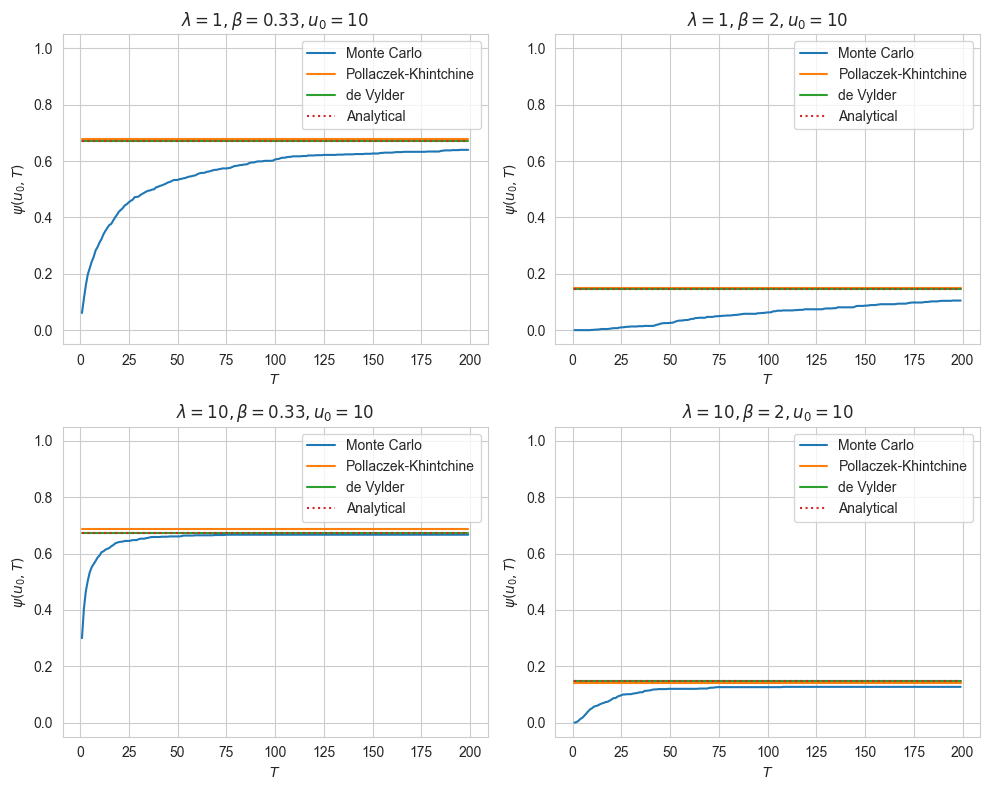

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
steps = 1000
T_vec = np.arange(1, 200)

for i, poiss_lamb in enumerate([1, 10]):
    for j, beta in enumerate([1/3, 2]):
        rp = RuinProcess("exp", {"lmbd":1/beta}, poisson_lbd=poiss_lamb, T=200)
        rp.MC_simulate(steps, T_vec)
        rp.MC_ruin_probability(u_vec = [10], plot = False)
        rp.PC_simulate(steps)
        rp.PC_ruin_probability(u_vec = [10], plot = False)
        rp.Vylder_simulate()
        rp.Vylder_ruin_probability(u_vec = np.array([10]), plot = False)
        axes[i, j].plot(T_vec, np.concatenate(list(rp.ruin_probability_MC.values())), label = "Monte Carlo")
        axes[i, j].plot(T_vec, rp.ruin_probability_PC * np.ones(199), label = "Pollaczek-Khintchine")
        axes[i, j].plot(T_vec, rp.ruin_probability_V * np.ones(199), label = "de Vylder")
        axes[i, j].plot(T_vec, (1/(1+rp.theta))*np.exp((-beta*rp.theta*10*np.ones(199))/(1+rp.theta)), label = "Analytical", ls = ':')
        axes[i, j].set_title(f"$\lambda = {poiss_lamb}, \\beta = {round(beta, 2)}, u_0 = 10$")
        axes[i, j].set_xlabel("$T$")
        axes[i, j].set_ylabel("$\psi(u_0, T)$")
        axes[i, j].set_ylim(-0.05, 1.05)
        axes[i, j].legend()
        plt.tight_layout()
plt.savefig("plots/task_1_T.svg")

## Task 2.

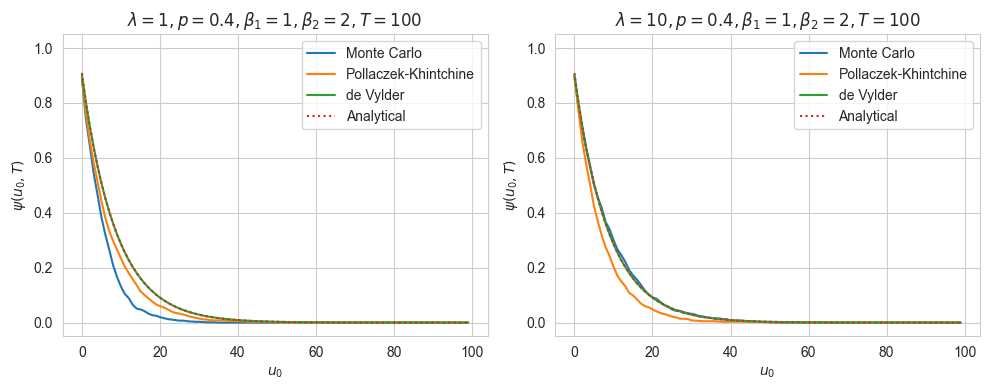

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
steps = 1000
u_vec = np.arange(0, 100)
pr, beta_1, beta_2 = 0.4, 1, 2

for i, poiss_lmbd  in enumerate([1, 10]):
    rp = RuinProcess("mixed", {"p": pr, "lmbd_1":1/beta_1, "lmbd_2": 1/beta_2}, poisson_lbd = poiss_lmbd, T=100) 
    rp.MC_simulate(steps, [100])
    rp.MC_ruin_probability(plot = False)
    rp.PC_simulate(steps)
    rp.PC_ruin_probability(plot = False)
    rp.Vylder_simulate()
    rp.Vylder_ruin_probability(plot = False)
    ax[i].plot(u_vec, rp.ruin_probability_MC[100], label = "Monte Carlo")
    ax[i].plot(u_vec, rp.ruin_probability_PC, label = "Pollaczek-Khintchine")
    ax[i].plot(u_vec, rp.ruin_probability_V, label = "de Vylder")
    p = (pr/beta_1)/(pr/beta_1 + (1-pr)/beta_2)
    rho = beta_1 * (1-p) + beta_2 * p
    r_1 = (rho + rp.theta * (beta_1 + beta_2) - np.sqrt((rho + rp.theta * (beta_1 + beta_2))**2 - 4*beta_1*beta_2*rp.theta*(1+rp.theta)))/(2*(1+rp.theta))
    r_2 = (rho + rp.theta * (beta_1 + beta_2) + np.sqrt((rho + rp.theta * (beta_1 + beta_2))**2 - 4*beta_1*beta_2*rp.theta*(1+rp.theta)))/(2*(1+rp.theta))
    psi = 1/((1+rp.theta)*(r_2-r_1)) * ((rho-r_1) * np.exp(-r_1 * u_vec) + (r_2 - rho) * np.exp(-r_2 * u_vec))
    ax[i].plot(u_vec, psi, label = "Analytical", ls = ":") 
    ax[i].set_title(f"$\lambda = {poiss_lmbd}, p = 0.4, \\beta_1 = 1, \\beta_2 = 2, T = 100$")
    ax[i].set_xlabel("$u_0$")
    ax[i].set_ylabel("$\psi(u_0, T)$")
    ax[i].set_ylim(-0.05, 1.05)
    ax[i].legend()
    plt.tight_layout()
plt.savefig("plots/task_2_u.svg")

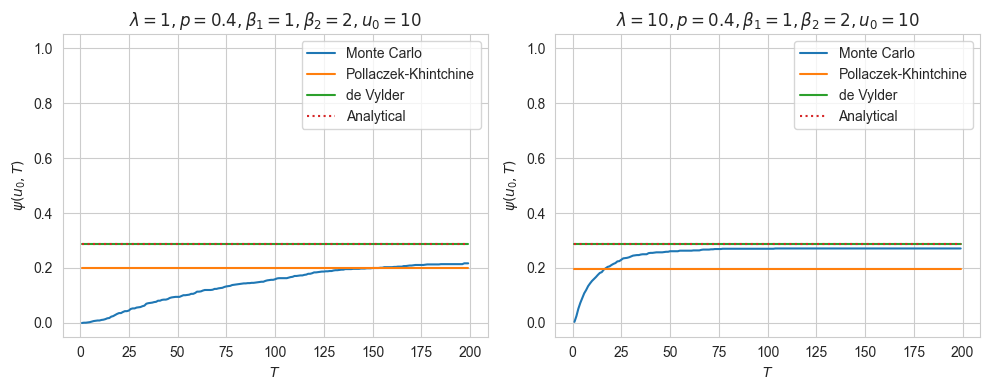

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
steps = 1000
T_vec = np.arange(1, 200)
u = 10

for i, poiss_lmbd  in enumerate([1, 10]):
    rp = RuinProcess("mixed", {"p": 0.4, "lmbd_1":1, "lmbd_2": 1/2}, poisson_lbd=poiss_lmbd, T=200)
    rp.MC_simulate(steps, T_vec)
    rp.MC_ruin_probability(u_vec = [10], plot = False)
    rp.PC_simulate(steps)
    rp.PC_ruin_probability(u_vec = [10], plot = False)
    rp.Vylder_simulate()
    rp.Vylder_ruin_probability(u_vec = np.array([10]), plot = False)
    ax[i].plot(T_vec, np.concatenate(list(rp.ruin_probability_MC.values())), label = "Monte Carlo")
    ax[i].plot(T_vec, rp.ruin_probability_PC * np.ones(199), label = "Pollaczek-Khintchine")
    ax[i].plot(T_vec, rp.ruin_probability_V * np.ones(199), label = "de Vylder")
    p = (pr/beta_1)/(pr/beta_1 + (1-pr)/beta_2)
    rho = beta_1 * (1-p) + beta_2 * p
    r_1 = (rho + rp.theta * (beta_1 + beta_2) - np.sqrt((rho + rp.theta * (beta_1 + beta_2))**2 - 4*beta_1*beta_2*rp.theta*(1+rp.theta)))/(2*(1+rp.theta))
    r_2 = (rho + rp.theta * (beta_1 + beta_2) + np.sqrt((rho + rp.theta * (beta_1 + beta_2))**2 - 4*beta_1*beta_2*rp.theta*(1+rp.theta)))/(2*(1+rp.theta))
    psi = 1/((1+rp.theta)*(r_2-r_1)) * ((rho-r_1) * np.exp(-r_1 * u * np.ones(199)) + (r_2 - rho) * np.exp(-r_2 * u * np.ones(199)))
    ax[i].plot(T_vec, psi, label = "Analytical", ls = ":") 
    ax[i].set_title(f"$\lambda = {poiss_lmbd}, p = 0.4, \\beta_1 = 1, \\beta_2 = 2, u_0 = 10$")
    ax[i].set_xlabel("$T$")
    ax[i].set_ylabel("$\psi(u_0, T)$")
    ax[i].set_ylim(-0.05, 1.05)
    ax[i].legend()
    plt.tight_layout()
plt.savefig("plots/task_2_T.svg")

## Task 3.

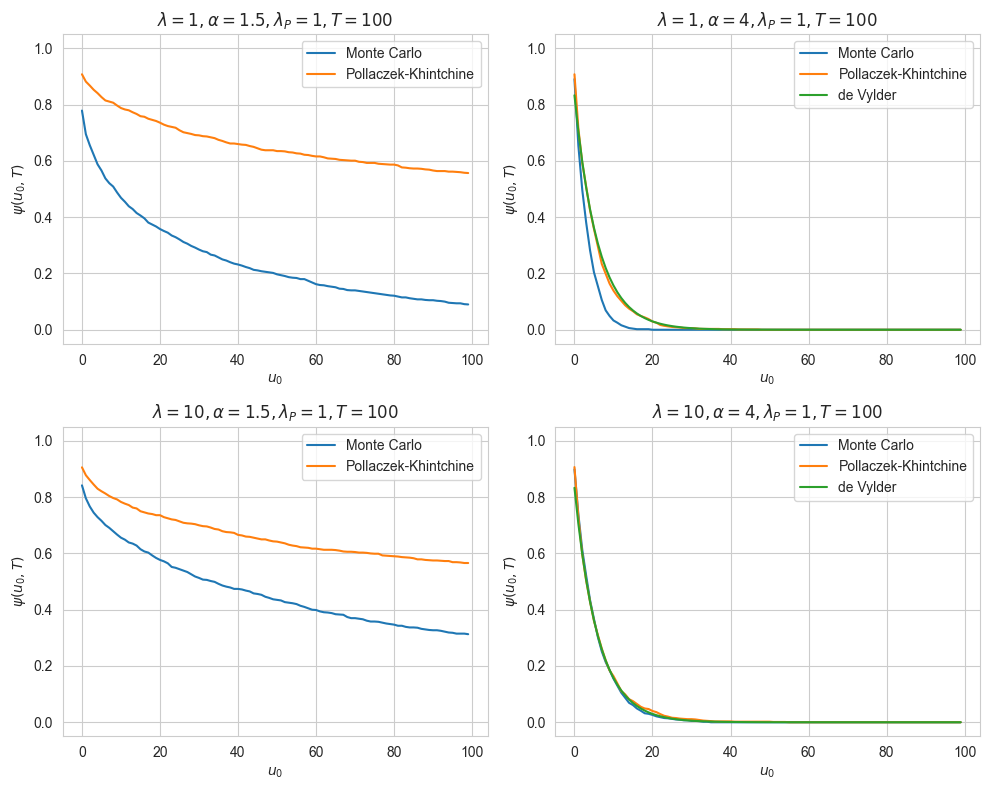

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
steps = 1000
u_vec = np.arange(0, 100)
lmbd = 1 # lambda Pareto

for i, poiss_lmbd  in enumerate([1, 10]):
    for j, alpha in enumerate([1.5, 4]):
        rp = RuinProcess("pareto", {"alpha": alpha, "lmbd": lmbd}, poisson_lbd = poiss_lmbd, T=100) 
        rp.MC_simulate(steps, [100])
        rp.MC_ruin_probability(plot = False)
        rp.PC_simulate(steps)
        rp.PC_ruin_probability(plot = False)
        rp.Vylder_simulate()
        rp.Vylder_ruin_probability(plot = False)
        axes[i, j].plot(u_vec, rp.ruin_probability_MC[100], label = "Monte Carlo")
        axes[i, j].plot(u_vec, rp.ruin_probability_PC, label = "Pollaczek-Khintchine")
        if not all(np.isnan(rp.ruin_probability_V)):
            axes[i, j].plot(u_vec, rp.ruin_probability_V, label = "de Vylder")
        axes[i, j].set_title(f"$\lambda = {poiss_lmbd}, \\alpha = {alpha}, \\lambda_P = {lmbd}, T = 100$")
        axes[i, j].set_xlabel("$u_0$")
        axes[i, j].set_ylabel("$\psi(u_0, T)$")
        axes[i, j].set_ylim(-0.05, 1.05)
        axes[i, j].legend()
        plt.tight_layout()
plt.savefig("plots/task_3_u.svg")

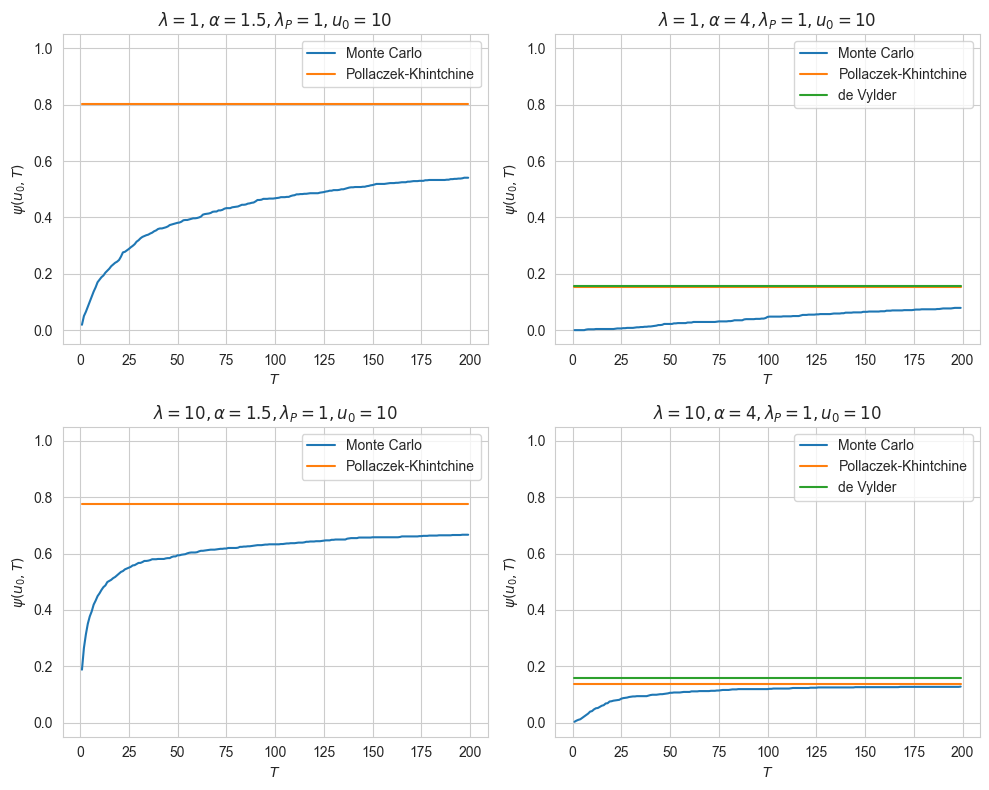

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
steps = 1000
lmbd = 1 # lambda Pareto
T_vec = np.arange(1, 200)

for i, poiss_lmbd  in enumerate([1, 10]):
    for j, alpha in enumerate([1.5, 4]):
        rp = RuinProcess("pareto", {"alpha": alpha, "lmbd": lmbd}, poisson_lbd = poiss_lmbd, T=200)
        rp.MC_simulate(steps, T_vec)
        rp.MC_ruin_probability(u_vec = [10], plot = False)
        rp.PC_simulate(steps)
        rp.PC_ruin_probability(u_vec = [10], plot = False)
        rp.Vylder_simulate()
        rp.Vylder_ruin_probability(u_vec = np.array([10]), plot = False)
        axes[i, j].plot(T_vec, np.concatenate(list(rp.ruin_probability_MC.values())), label = "Monte Carlo")
        axes[i, j].plot(T_vec, rp.ruin_probability_PC * np.ones(199), label = "Pollaczek-Khintchine")
        if not all(np.isnan(rp.ruin_probability_V)):
            axes[i, j].plot(T_vec, rp.ruin_probability_V * np.ones(199), label = "de Vylder")
        axes[i, j].set_title(f"$\lambda = {poiss_lmbd}, \\alpha = {alpha}, \\lambda_P = {lmbd}, u_0 = 10$")
        axes[i, j].set_xlabel("$T$")
        axes[i, j].set_ylabel("$\psi(u_0, T)$")
        axes[i, j].set_ylim(-0.05, 1.05)
        axes[i, j].legend()
        plt.tight_layout()
plt.savefig("plots/task_3_T.svg")

## Task 4.

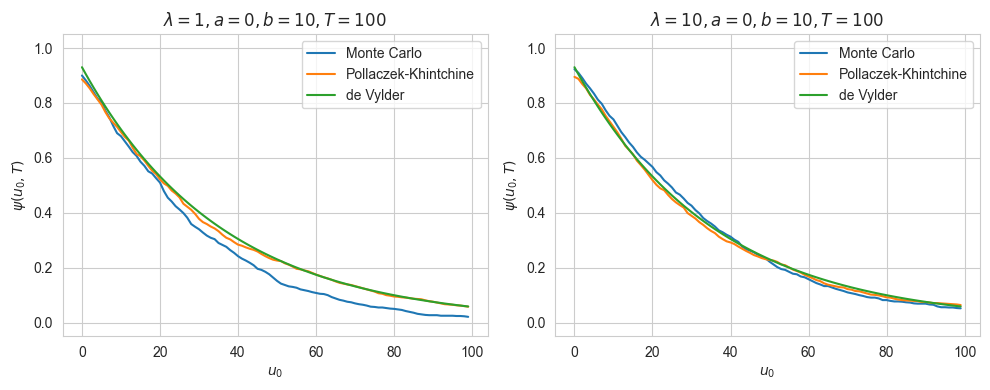

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
steps = 1000
u_vec = np.arange(0, 100)

for i, poiss_lmbd  in enumerate([1, 10]):
    rp = RuinProcess("uniform", {"a": 0, "b": 10}, poisson_lbd = poiss_lmbd, T=100) 
    rp.MC_simulate(steps, [100])
    rp.MC_ruin_probability(plot = False)
    rp.PC_simulate(steps)
    rp.PC_ruin_probability(plot = False)
    rp.Vylder_simulate()
    rp.Vylder_ruin_probability(plot = False)
    axes[i].plot(u_vec, rp.ruin_probability_MC[100], label = "Monte Carlo")
    axes[i].plot(u_vec, rp.ruin_probability_PC, label = "Pollaczek-Khintchine")
    axes[i].plot(u_vec, rp.ruin_probability_V, label = "de Vylder")
    axes[i].set_title(f"$\lambda = {poiss_lmbd}, a = {0}, b = {10}, T = 100$")
    axes[i].set_xlabel("$u_0$")
    axes[i].set_ylabel("$\psi(u_0, T)$")
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].legend()
    plt.tight_layout()
plt.savefig("plots/task_4_u.svg")

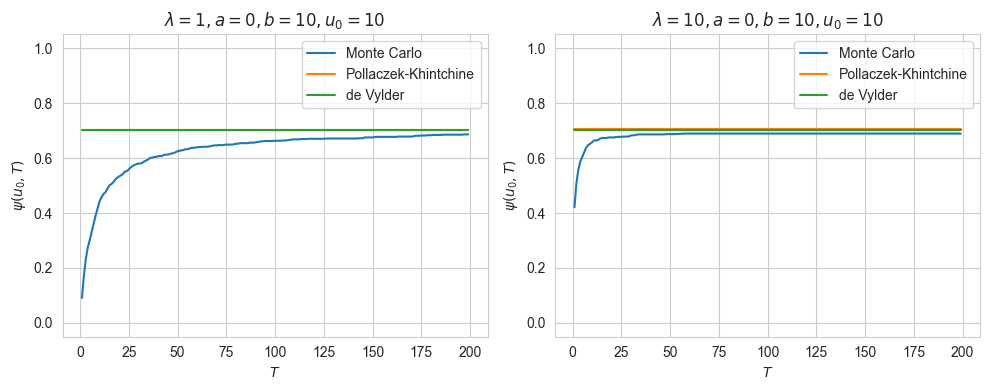

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
steps = 1000
T_vec = np.arange(1, 200)
u = 10

for i, poiss_lmbd  in enumerate([1, 10]):
    rp = RuinProcess("uniform", {"a": 0, "b": 10}, poisson_lbd = poiss_lmbd, T=200)
    rp.MC_simulate(steps, T_vec)
    rp.MC_ruin_probability(u_vec = [10], plot = False)
    rp.PC_simulate(steps)
    rp.PC_ruin_probability(u_vec = [10], plot = False)
    rp.Vylder_simulate()
    rp.Vylder_ruin_probability(u_vec = np.array([10]), plot = False)
    ax[i].plot(T_vec, np.concatenate(list(rp.ruin_probability_MC.values())), label = "Monte Carlo")
    ax[i].plot(T_vec, rp.ruin_probability_PC * np.ones(199), label = "Pollaczek-Khintchine")
    ax[i].plot(T_vec, rp.ruin_probability_V * np.ones(199), label = "de Vylder")
    ax[i].set_title(f"$\lambda = {poiss_lmbd}, a = {0}, b = {10}, u_0 = 10$")
    ax[i].set_xlabel("$T$")
    ax[i].set_ylabel("$\psi(u_0, T)$")
    ax[i].set_ylim(-0.05, 1.05)
    ax[i].legend()
    plt.tight_layout()
plt.savefig("plots/task_4_T.svg")